# Lab:  Model selection for Ames Iowa housing data

In this lab, you will apply polynomial regression with model order selection to a housing dataset. 

Before doing this lab, you should review the polynomial model selection demo.  In addition to the concepts in that demo, you will learn to:
* Fit a polynomial model for a given model order 
* Select the model order via K-fold cross-validation and the one-standard-error rule.
  

## Loading the data

We first load the standard packages.

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

We now load the house_prices dataset, which we can get from openml.

In [4]:
from sklearn.datasets import fetch_openml
housing = fetch_openml(name="house_prices", as_frame=True)

Let's see what the dataset contains.

In [5]:
print(housing.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


The structure `housing` is made up of
* `data`: which contains the feature data
* `target`: which contains target data
* `feature_names`: which contains the names of the features, 
* `target_names`: which contains the names of the targets, 
* `DESCR`: which describes the dataset, 
and a few other categories

Let's print the description.

In [6]:
print(housing.DESCR)

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1

Let's turn this dataset into a `pandas` dataframe for ease of handling.

In [7]:
import pandas as pd
df = pd.DataFrame(housing.data)
df[housing.target_names[0]] = pd.DataFrame(housing.target)
df.head(6)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,...,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal,208500.0
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,...,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal,181500.0
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal,223500.0
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal,250000.0
5,6.0,50.0,RL,85.0,14115.0,Pave,None,IR1,Lvl,AllPub,...,0.0,None,MnPrv,Shed,700.0,10.0,2009.0,WD,Normal,143000.0


Now, create the feature vector `x` using the values in the `LotArea` column using the `numpy.array` command.
Similarly, create the target vector `y` using the values in the `SalePrice` column.

In [8]:
# TODO
# x = ...
# y = ...

x = np.array(df['LotArea'])
y = np.array(df['SalePrice'])
#y = df['SalePrice']

# Fitting Models with Different Orders
We will now fit the polynomial model to the data using order d = 1 and order d = 5, for illustration.

For this, we'll use the `polyfit` command of the `numpy.polynomial.polynomial` library.

Text(0, 0.5, 'y')

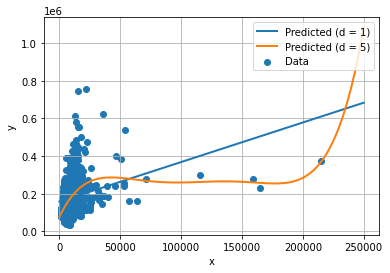

In [9]:
# TODO 
# Import polynomial library
# d1 = 1
# d2 = 5
# beta1 = 
# beta2 =
# xp = # grid of feature values
# yp_hat1 = # target prediction on grid using polynomial order d1
# yp_hat2 = # target prediction on grid using polynomial order d2
# Make a scatterplot and superimpose prediction curves for d1 and d2
# Add grid lines, axis labels, and a legend

import numpy.polynomial.polynomial as poly
d1 = 1
d2 = 5

beta1_hat = poly.polyfit(x,y,d1)
beta2_hat = poly.polyfit(x,y,d2)

# Plot prediction model
#xp = np.linspace(2000,200000,100)
xp = np.linspace(0,250000,100)
yp_hat1 = poly.polyval(xp,beta1_hat)
yp_hat2 = poly.polyval(xp,beta2_hat)
plt.plot(xp,yp_hat1,linewidth=2,label='Predicted (d = 1)')
plt.plot(xp,yp_hat2,linewidth=2,label='Predicted (d = 5)')

# Plot data
plt.scatter(x,y,label='Data')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')


How do these two model orders perform?  Are the results as expected? Can we do better?

## K-fold Cross-Validation

We now optimize the polynomial model order using 5-fold cross-validation.  You can follow the method used in the polynomial demo.  The first step is to create a matrix of test MSE values over all hypothesized model orders and all splits.

In [10]:
from sklearn import model_selection

# TODO
# Create a k-fold object

k = 5
kfo = model_selection.KFold(n_splits=k,shuffle=True)

# Test model orders d between 0 and 5 
dtest = np.arange(0,5)
nd = len(dtest)

MSEts = np.zeros((nd,k))

for isplit, Ind in enumerate(kfo.split(x)): # enumerate returns a counter (isplit) and a list (Ind)

    # Get the training data in the split
    Itr, Its = Ind
    #kfo.split( ) produced Ind, which contains a pair of index sets for each fold
    xtr = x[Itr]
    ytr = y[Itr]
    xts = x[Its]
    yts = y[Its]
    
    # Loop over the model order
    for it, d in enumerate(dtest):
        
        # Fit data on training data
        beta_hat = poly.polyfit(xtr,ytr,d)    
        yhat = poly.polyval(xts,beta_hat)
        MSEts[it,isplit] = np.mean((yhat-yts)**2)

MSEts

array([[7.70499095e+09, 5.59664488e+09, 7.74929635e+09, 5.95646679e+09,
        4.70200568e+09],
       [7.19110483e+09, 5.05667360e+09, 7.72125232e+09, 5.42412045e+09,
        4.63166396e+09],
       [6.88690311e+09, 4.59413455e+09, 8.21550750e+09, 4.89497792e+09,
        4.29329963e+09],
       [6.56255290e+09, 4.43682512e+09, 7.76274114e+09, 4.78635791e+09,
        4.21892608e+09],
       [6.43700469e+09, 4.45610025e+09, 1.42533425e+10, 4.78322392e+09,
        4.26690050e+09]])

Next, compute the mean and standard error of the MSE over the folds for each model order.  The standard error is defined as the standard deviation divided by $\sqrt{K}$, where $K$ is the number of folds.  You can use `ddof=1` in `np.std` to get an unbiased SE estimate.

With these MSE statistics, use the one-standard-error rule to find the best model order.  Print out the model order that minimizes mean test MSE, as well as the model order estimated by the one-standard-error rule.

In [11]:
# TODO
# compute mean and standard error of MSE
MSE_mean = np.mean(MSEts,axis=1)
MSE_se = np.std(MSEts,axis=1,ddof=1)/np.sqrt(k)

# find model order that minimizes test MSE
imin = np.argmin(MSE_mean)
print("Model order that minimises test MSE is {0:d}".format(dtest[imin]))

# estimate model order according to the one-standard-error rule
# Find the minimum MSE target
MSE_tgt = MSE_mean[imin] + MSE_se[imin]

# Find the lowest model order below the target
I = np.where(MSE_mean <= MSE_tgt)[0]
iose = I[0]
dose = dtest[iose]
print("Model order estimated by the one-standard-error rule is {0:d}".format(dose))


Model order that minimises test MSE is 3
Model order estimated by the one-standard-error rule is 1


Next, illustrate the one-standard-error-rule procedure by making a plot that shows the following:
* the mean test MSE curve with errorbars
* a dashed line showing the model order yielding minimum mean test MSE
* a dashed line showing the target MSE
* a dashed line showing the model order estimated by the one-standard-error rule

Also, add a grid and axis labels to your plot.  Use ylim if needed to zoom into the relevant range.

The estimated model order is 1


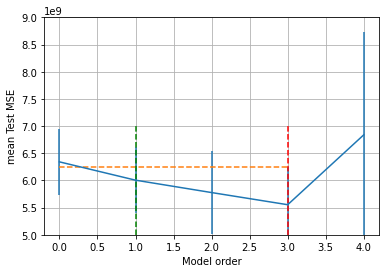

In [19]:
# plot mean test MSE curve with errorbars
plt.errorbar(dtest, MSE_mean, yerr=MSE_se, fmt='-')

# plot dashed line showing the model order yielding minimum mean test MSE
plt.plot([dtest[imin],dtest[imin]], [5e9,7e9], 'r--')

# plot dashed line showing the target MSE
plt.plot([dtest[0],dtest[imin]], [MSE_tgt, MSE_tgt], '--')

# plot dashed line showing the model order estimated by the one-standard-error rule
plt.plot([dose,dose], [5e9,7e9], 'g--')

plt.ylim(5e9,9e9)
plt.xlabel('Model order')
plt.ylabel('mean Test MSE')
plt.grid()

# Print results
print("The estimated model order is %d" % dose)

Finally, make a scatter plot of the data and superimpose
* the polynomial prediction curve with the order that minimizes mean MSE
* the polynomial prediction curve with the order selected by the one-standard-error rule

As usual, add grid lines, axis labels, and a legend to your curve

Text(0, 0.5, 'Sale Price')

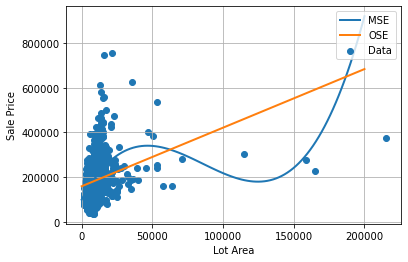

In [16]:
# fit the model

# compute the polynomial prediction curve 

# make scatterplot and superimpose curves

# add legend, axis labels, grid

beta3_hat = poly.polyfit(x,y,imin)
beta4_hat = poly.polyfit(x,y,dose)
yp_hat3 = poly.polyval(xp,beta3_hat)
yp_hat4 = poly.polyval(xp,beta4_hat)

xp = np.linspace(0,200000,100)
# plt.scatter(x,y)
# plt.plot(xp,yp_hat3)
# plt.plot(xp,yp_hat4)
# plt.grid()
# plt.legend(labels=['MSE','One Standard error'],loc='upper right')
# plt.xlabel('Lot Area')
# plt.ylabel('Sale Price')

plt.plot(xp,yp_hat3,linewidth=2,label='MSE')
plt.plot(xp,yp_hat4,linewidth=2,label='OSE')

# Plot data
plt.scatter(x,y,label='Data')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Lot Area')
plt.ylabel('Sale Price')

Note that because the shuffling done by the K-fold object is random, the results may vary a bit every time you run the code.  If that is distracting, you can fix the `random_seed` of the K-fold object.